In [85]:
import sys
from dotenv import load_dotenv
import os

load_dotenv()

sys.path.append(os.getenv("ROOT"))

In [86]:
import polars as pl
import pandas as pd
import statsmodels.api as sm
import numpy as np
from datetime import date
from silverfund.datasets.crsp_monthly import CRSPMonthly
from silverfund.datasets.barra_specific_returns import BarraSpecificReturns
from silverfund.datasets.crsp_monthly import CRSPMonthly
from silverfund.datasets.master_monthly import MasterMonthly
import seaborn as sns
import matplotlib.pyplot as plt

In [87]:
# start = date(1995, 7, 31)
start = date(2006, 1, 1)
end = date(2024, 12, 31)

## Testing economic theory behind reversal.
 - Use monthly trading volume as proxy for news events to inform reversal strength.


In [88]:
crsp_monthly = (
    CRSPMonthly(start_date=start, end_date=end)
    .load_all()
    .select(["permno", "date", "prc", "ret", "vol"])
)

crsp_monthly

permno,date,prc,ret,vol
i64,date,f64,f64,f64
10001,2006-01-31,9.49,-0.016495,757.0
10001,2006-02-28,9.39,-0.010537,439.0
10001,2006-03-31,10.99,0.170394,777.0
10001,2006-04-28,9.95,-0.094632,883.0
10001,2006-05-31,9.766,-0.010452,319.0
…,…,…,…,…
93436,2024-08-30,214.11,-0.077391,1.6108365e7
93436,2024-09-30,261.63,0.221942,1.6042065e7
93436,2024-10-31,249.85001,-0.045025,1.9014312e7


In [89]:
crsp_monthly = crsp_monthly.with_columns(pl.col("ret").shift(1).over("permno").alias("rev"))
crsp_monthly = crsp_monthly.with_columns(
    pl.col("vol").pct_change(1).over("permno").alias("vol_diff")
)

crsp_monthly = crsp_monthly.drop_nulls()
# crsp_monthly = crsp_monthly.with_columns(
#     ((pl.col("rev") - pl.col("rev").mean()) / pl.col("rev").std()).over("date").alias("rev_score")
# )

crsp_monthly = crsp_monthly.with_columns(
    ((pl.col("rev").mean() - pl.col("rev")) / pl.col("rev").std()).over("date").alias("rev_score")
)


df = crsp_monthly.to_pandas()
df

,permno,date,prc,ret,vol,rev,vol_diff,rev_score
0,10001,2006-02-28,9.39000,-0.010537,439.0,-0.016495,-0.420079,0.630741
1,10001,2006-03-31,10.99000,0.170394,777.0,-0.010537,0.769932,0.134606
2,10001,2006-04-28,9.95000,-0.094632,883.0,0.170394,0.136422,-1.004819
3,10001,2006-05-31,9.76600,-0.010452,319.0,-0.094632,-0.638732,0.806704
4,10001,2006-06-30,9.02000,-0.076387,1186.0,-0.010452,2.717868,-0.316975
...,...,...,...,...,...,...,...,...
890276,93436,2024-08-30,214.11000,-0.077391,16108365.0,0.172781,-0.450000,-0.387210
890277,93436,2024-09-30,261.63000,0.221942,16042065.0,-0.077391,-0.004116,0.252403
890278,93436,2024-10-31,249.85001,-0.045025,19014312.0,0.221942,0.185278,-1.052236
890279,93436,2024-11-29,345.16000,0.381469,20821313.0,-0.045025,0.095034,0.183516


In [90]:
def calc_beta_and_tstat(x):
    beta = np.cov(x["vol_diff"], x["rev_score"])[0, 1] / np.var(x["vol_diff"])

    # Compute standard error of beta and t-stat, from perplexity
    se_beta = np.sqrt(np.var(x["rev_score"]) / (len(x) - 1)) / np.sqrt(np.var(x["vol_diff"]))
    t_stat = beta / se_beta
    return pd.Series({"beta": beta, "t_stat": t_stat})


beta = df.groupby(["date"]).apply(calc_beta_and_tstat).reset_index()
beta.index = beta["date"]
beta = beta[["beta", "t_stat"]]
beta

/home/bwaits/Research/sf-trading-system/.venv/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2888: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]
/home/bwaits/Research/sf-trading-system/.venv/lib/python3.11/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
/tmp/ipykernel_459728/652819378.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  beta = df.groupby(['date']).apply(calc_beta_and_tstat).reset_index()


,beta,t_stat
date,,
2006-02-28,0.011631,2.112886
2006-03-31,-0.000924,-0.311138
2006-04-28,0.009903,1.114110
2006-05-31,NaN,NaN
2006-06-30,-0.053219,-5.090090
...,...,...
2024-08-30,0.004880,3.396674
2024-09-30,0.002768,2.780290
2024-10-31,0.007600,5.430940


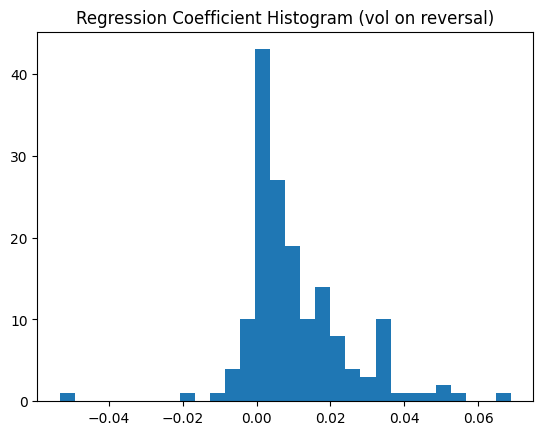

In [91]:
plt.hist(beta["beta"], bins=30)
plt.title("Regression Coefficient Histogram (vol on reversal)")
# sns.kdeplot(beta['beta'], bw_adjust=1.5)
plt.show()

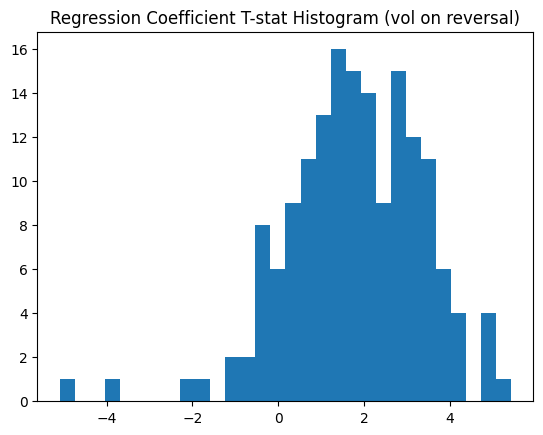

In [92]:
plt.hist(beta["t_stat"], bins=30)
plt.title("Regression Coefficient T-stat Histogram (vol on reversal)")
# sns.kdeplot(beta['t_stat'], bw_adjust=10)
plt.show()

## Testing Barra residual short term mean reversal.
 - 


In [93]:
# master = MasterMonthly(start_date=start, end_date=end, quiet=False).load_all().to_pandas()
master = MasterMonthly(start_date=start, end_date=end, quiet=False).load_all()
master

Loading Barra Specific Returns: 100%|██████████| 19/19 [00:17<00:00,  1.07it/s]


Joining Universe + Barra Returns = Master
Joining Master + Barra Risk = Master
Joining Master + Barra Specific Returns = Master


date,barrid,currency,mktcap,price,logret,ret,div_yield,total_risk,spec_risk,histbeta,predbeta,log_spec_ret,spec_ret
date,str,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
2009-05-29,"""CAN17B1""","""CAD""",1.1091e9,16.16,-0.002316,-0.002313,0.0,0.885616,0.7106818,0.776138,1.280289,-0.266723,-0.234115
2006-06-30,"""CAN1G71""","""CAD""",5.5439e9,28.68,-0.014538,-0.014433,0.0,0.224936,0.169787,0.691921,0.690204,0.006022,0.00604
2006-07-31,"""CAN1G71""","""CAD""",5.4473e9,28.18,-0.02211,-0.021867,0.0,0.229176,0.174264,0.692143,0.689352,0.044817,0.045836
2023-04-28,"""GERRJO1""","""EUR""",7.59564864e8,18.0,-0.00554,-0.005524,0.0,0.495119,0.432869,0.325733,0.593054,-0.045877,-0.044841
2013-07-31,"""USA06Z1""","""USD""",6.006157e8,6.26,-0.120264,-0.113314,0.0,0.593653,0.550569,0.328385,0.34349,-0.204162,-0.18467
…,…,…,…,…,…,…,…,…,…,…,…,…,…
2024-12-31,"""USBQND1""","""USD""",1.0524e8,5.22,0.085966,0.08977,0.0,0.945033,0.865889,0.887422,1.289597,0.134304,0.14374
2024-12-31,"""USBQO11""","""USD""",9.6186e8,22.9,-0.099273,-0.094504,null,0.524401,0.455475,0.674401,0.904928,-0.040956,-0.040128
2024-12-31,"""USBQOE1""","""USD""",4.5533e9,19.39,-0.205768,-0.185978,0.0,0.385611,0.315659,1.046291,1.157971,-0.182472,-0.166792


In [94]:
df = master.clone()

In [95]:
df

date,barrid,currency,mktcap,price,logret,ret,div_yield,total_risk,spec_risk,histbeta,predbeta,log_spec_ret,spec_ret
date,str,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
2009-05-29,"""CAN17B1""","""CAD""",1.1091e9,16.16,-0.002316,-0.002313,0.0,0.885616,0.7106818,0.776138,1.280289,-0.266723,-0.234115
2006-06-30,"""CAN1G71""","""CAD""",5.5439e9,28.68,-0.014538,-0.014433,0.0,0.224936,0.169787,0.691921,0.690204,0.006022,0.00604
2006-07-31,"""CAN1G71""","""CAD""",5.4473e9,28.18,-0.02211,-0.021867,0.0,0.229176,0.174264,0.692143,0.689352,0.044817,0.045836
2023-04-28,"""GERRJO1""","""EUR""",7.59564864e8,18.0,-0.00554,-0.005524,0.0,0.495119,0.432869,0.325733,0.593054,-0.045877,-0.044841
2013-07-31,"""USA06Z1""","""USD""",6.006157e8,6.26,-0.120264,-0.113314,0.0,0.593653,0.550569,0.328385,0.34349,-0.204162,-0.18467
…,…,…,…,…,…,…,…,…,…,…,…,…,…
2024-12-31,"""USBQND1""","""USD""",1.0524e8,5.22,0.085966,0.08977,0.0,0.945033,0.865889,0.887422,1.289597,0.134304,0.14374
2024-12-31,"""USBQO11""","""USD""",9.6186e8,22.9,-0.099273,-0.094504,null,0.524401,0.455475,0.674401,0.904928,-0.040956,-0.040128
2024-12-31,"""USBQOE1""","""USD""",4.5533e9,19.39,-0.205768,-0.185978,0.0,0.385611,0.315659,1.046291,1.157971,-0.182472,-0.166792


In [96]:
# reversal signals
df = df.with_columns(pl.col("spec_ret").shift(1).over("barrid").alias("barra_rev"))
df = df.with_columns(pl.col("ret").shift(1).over("barrid").alias("rev"))

# filter low price and nan vals
df = df.with_columns(pl.col("price").shift(1).over("barrid").alias("prclag"))
df = df.filter(pl.col("prclag") > 5)
df = df.drop_nulls(subset=["rev"])
df = df.drop_nulls(subset=["barra_rev"])

df

date,barrid,currency,mktcap,price,logret,ret,div_yield,total_risk,spec_risk,histbeta,predbeta,log_spec_ret,spec_ret,barra_rev,rev,prclag
date,str,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
2006-07-31,"""CAN1G71""","""CAD""",5.4473e9,28.18,-0.02211,-0.021867,0.0,0.229176,0.174264,0.692143,0.689352,0.044817,0.045836,0.00604,-0.014433,28.68
2013-08-30,"""USA06Z1""","""USD""",5.9463375e8,6.17,-0.014481,-0.014377,0.0,0.584602,0.5358,0.708043,0.753349,-0.012162,-0.012088,-0.18467,-0.113314,6.26
2013-09-30,"""USA06Z1""","""USD""",4.0188375e8,4.17,-0.391781,-0.324148,0.0,0.619852,0.576723,0.499476,0.539619,-0.49517,-0.390532,-0.012088,-0.014377,6.17
2013-11-29,"""USA06Z1""","""USD""",6.071625e8,6.3,0.172845,0.188682,0.0,0.61865,0.572363,0.882678,1.016568,0.066841,0.069125,0.392418,0.270982,5.3
2013-12-31,"""USA06Z1""","""USD""",9.0427e8,8.74,0.327358,0.387298,0.0,0.618896,0.5743582,0.824176,0.941171,0.345907,0.413271,0.069125,0.188682,6.3
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
2024-11-29,"""USBQLB1""","""USD""",5.9244e9,24.35,-0.199962,-0.181238,0.0,0.620162,0.551095,0.743459,1.38756,-0.324894,-0.277396,-0.08451,-0.077828,29.74
2024-12-31,"""USBQLB1""","""USD""",5.1166e9,21.03,-0.146582,-0.136345,0.0,0.594512,0.52903,0.767573,1.312122,-0.060398,-0.05861,-0.277396,-0.181238,24.35
2024-11-29,"""USBQLU1""","""USD""",2.5483e9,24.26,0.069552,0.072028,0.0,0.302187,0.238206,0.538703,0.805339,-0.028463,-0.028062,-0.060781,-0.070636,22.63


In [97]:
labels = [str(x) for x in range(10)]

df = df.with_columns(pl.col("rev").qcut(10, labels=labels).over("date").alias("bin"))
df = df.with_columns(pl.col("barra_rev").qcut(10, labels=labels).over("date").alias("barra_bin"))

df

date,barrid,currency,mktcap,price,logret,ret,div_yield,total_risk,spec_risk,histbeta,predbeta,log_spec_ret,spec_ret,barra_rev,rev,prclag,bin,barra_bin
date,str,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,cat,cat
2006-07-31,"""CAN1G71""","""CAD""",5.4473e9,28.18,-0.02211,-0.021867,0.0,0.229176,0.174264,0.692143,0.689352,0.044817,0.045836,0.00604,-0.014433,28.68,"""4""","""5"""
2013-08-30,"""USA06Z1""","""USD""",5.9463375e8,6.17,-0.014481,-0.014377,0.0,0.584602,0.5358,0.708043,0.753349,-0.012162,-0.012088,-0.18467,-0.113314,6.26,"""0""","""0"""
2013-09-30,"""USA06Z1""","""USD""",4.0188375e8,4.17,-0.391781,-0.324148,0.0,0.619852,0.576723,0.499476,0.539619,-0.49517,-0.390532,-0.012088,-0.014377,6.17,"""6""","""4"""
2013-11-29,"""USA06Z1""","""USD""",6.071625e8,6.3,0.172845,0.188682,0.0,0.61865,0.572363,0.882678,1.016568,0.066841,0.069125,0.392418,0.270982,5.3,"""9""","""9"""
2013-12-31,"""USA06Z1""","""USD""",9.0427e8,8.74,0.327358,0.387298,0.0,0.618896,0.5743582,0.824176,0.941171,0.345907,0.413271,0.069125,0.188682,6.3,"""9""","""8"""
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
2024-11-29,"""USBQLB1""","""USD""",5.9244e9,24.35,-0.199962,-0.181238,0.0,0.620162,0.551095,0.743459,1.38756,-0.324894,-0.277396,-0.08451,-0.077828,29.74,"""2""","""1"""
2024-12-31,"""USBQLB1""","""USD""",5.1166e9,21.03,-0.146582,-0.136345,0.0,0.594512,0.52903,0.767573,1.312122,-0.060398,-0.05861,-0.277396,-0.181238,24.35,"""0""","""0"""
2024-11-29,"""USBQLU1""","""USD""",2.5483e9,24.26,0.069552,0.072028,0.0,0.302187,0.238206,0.538703,0.805339,-0.028463,-0.028062,-0.060781,-0.070636,22.63,"""2""","""2"""


In [98]:
port = df.group_by(["date", "bin"]).agg(pl.col("ret").mean())
barra_port = df.group_by(["date", "barra_bin"]).agg(pl.col("ret").mean())


port = port.pivot(on="bin", index="date", values="ret")
barra_port = barra_port.pivot(on="barra_bin", index="date", values="ret")


port = port.select(["date"] + labels)
barra_port = barra_port.select(["date"] + labels)


port = port.sort(by="date")
barra_port = barra_port.sort(by="date")

# port
barra_port

date,0,1,2,3,4,5,6,7,8,9
date,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
2006-02-28,-0.008103,0.014433,0.013387,0.000752,0.000767,0.000052,0.003264,-0.008603,0.000096,-0.010913
2006-03-31,0.029033,0.039566,0.039617,0.036241,0.033543,0.018327,0.025979,0.031565,0.058613,0.040345
2006-04-28,-0.000111,0.000174,0.00178,0.009595,-0.001357,0.000178,-0.000453,0.003078,0.004138,0.003899
2006-05-31,-0.056752,-0.047727,-0.038986,-0.032437,-0.041755,-0.033925,-0.044471,-0.052704,-0.051167,-0.052125
2006-06-30,0.001102,-0.00603,-0.000978,0.011785,0.003666,0.005974,0.000831,0.005727,0.00106,-0.005034
…,…,…,…,…,…,…,…,…,…,…
2024-08-30,-0.036097,-0.008031,0.001501,-0.017388,-0.001559,0.007539,0.002873,0.001283,-0.01206,-0.019034
2024-09-30,-0.00703,0.009021,0.00789,0.007162,0.010315,0.011468,0.017903,0.003713,0.003538,0.019615
2024-10-31,-0.002364,-0.018519,-0.014652,-0.013017,-0.012387,-0.014303,-0.00469,-0.010528,-0.012678,0.010119


In [99]:
port = port.with_columns((pl.col("0") - pl.col("9")).alias("spread"))
barra_port = barra_port.with_columns((pl.col("0") - pl.col("9")).alias("spread"))

# Unpivot dataframe
port = port.unpivot(index="date", variable_name="bin", value_name="ret")
# barra_port = barra_port.unpivot(index="date", variable_name="barra_bin", value_name="log_spec_ret")
barra_port = barra_port.unpivot(index="date", variable_name="barra_bin", value_name="ret")

# Sort
port = port.sort(by=["date", "bin"])
barra_port = barra_port.sort(by=["date", "barra_bin"])

# port
barra_port

date,barra_bin,ret
date,str,f64
2006-02-28,"""0""",-0.008103
2006-02-28,"""1""",0.014433
2006-02-28,"""2""",0.013387
2006-02-28,"""3""",0.000752
2006-02-28,"""4""",0.000767
…,…,…
2024-12-31,"""6""",-0.079885
2024-12-31,"""7""",-0.068576
2024-12-31,"""8""",-0.06001


In [100]:
# Calculate mean, std, sharpe, and tstat of each portfolio

# Mean, std, and count
result = port.group_by("bin").agg(
    [
        pl.col("ret").mean().cast(pl.Float64).alias("mean"),
        pl.col("ret").std().cast(pl.Float64).alias("std"),
        pl.col("ret").count().cast(pl.Float64).alias("count"),
    ]
)

# Sharpe
result = result.with_columns(
    ((pl.col("mean") * 12) / (pl.col("std") * np.sqrt(12)))
    .cast(pl.Float64)
    .alias("annualized_sharpe")
)

# Tstat
result = result.with_columns(
    (pl.col("mean") / (pl.col("std") / pl.col("count").sqrt())).cast(pl.Float64).alias("tstat")
)

# Sort
result = result.sort(by="bin")

# Transpose
result = result.transpose(include_header=True, column_names="bin", header_name="statistic")

print("Monthly results")
result

Monthly results


statistic,0,1,2,3,4,5,6,7,8,9,spread
str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""mean""",0.006859,0.008315,0.009225,0.009289,0.009597,0.009007,0.007987,0.007287,0.006342,0.005751,0.001109
"""std""",0.08158,0.066419,0.060489,0.057198,0.0546,0.053624,0.052979,0.052915,0.053772,0.060824,0.044434
"""count""",227.0,227.0,227.0,227.0,227.0,227.0,227.0,227.0,227.0,227.0,227.0
"""annualized_sharpe""",0.291273,0.43368,0.5283,0.562564,0.608854,0.581824,0.522248,0.477047,0.408555,0.327528,0.086428
"""tstat""",1.266843,1.886217,2.29775,2.446776,2.648108,2.530544,2.271428,2.074834,1.77694,1.424528,0.375904


In [101]:
barra_port

date,barra_bin,ret
date,str,f64
2006-02-28,"""0""",-0.008103
2006-02-28,"""1""",0.014433
2006-02-28,"""2""",0.013387
2006-02-28,"""3""",0.000752
2006-02-28,"""4""",0.000767
…,…,…
2024-12-31,"""6""",-0.079885
2024-12-31,"""7""",-0.068576
2024-12-31,"""8""",-0.06001


In [102]:
# Calculate mean, std, sharpe, and tstat of each portfolio

# Mean, std, and count
result = barra_port.group_by("barra_bin").agg(
    [
        pl.col("ret").mean().cast(pl.Float64).alias("mean"),
        pl.col("ret").std().cast(pl.Float64).alias("std"),
        pl.col("ret").count().cast(pl.Float64).alias("count"),
    ]
)

# Sharpe
result = result.with_columns(
    ((pl.col("mean") * 12) / (pl.col("std") * np.sqrt(12)))
    .cast(pl.Float64)
    .alias("annualized_sharpe")
)

# Tstat
result = result.with_columns(
    (pl.col("mean") / (pl.col("std") / pl.col("count").sqrt())).cast(pl.Float64).alias("tstat")
)

# Sort
result = result.sort(by="barra_bin")

# Transpose
result = result.transpose(include_header=True, column_names="barra_bin", header_name="statistic")

print("Monthly results")
result

Monthly results


statistic,0,1,2,3,4,5,6,7,8,9,spread
str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""mean""",0.008992,0.009322,0.010158,0.009197,0.009409,0.008059,0.007658,0.006911,0.005785,0.00416,0.004831
"""std""",0.075729,0.062859,0.059891,0.055921,0.053145,0.05345,0.053647,0.05454,0.056696,0.061713,0.027646
"""count""",227.0,227.0,227.0,227.0,227.0,227.0,227.0,227.0,227.0,227.0,227.0
"""annualized_sharpe""",0.411306,0.513732,0.587523,0.569749,0.613328,0.522314,0.494474,0.438943,0.353472,0.233528,0.605353
"""tstat""",1.788907,2.23439,2.555329,2.478027,2.667567,2.271716,2.15063,1.909107,1.537368,1.015689,2.632878


In [103]:
# Create backtest plot

# Log returns
port = port.with_columns(pl.col("ret").log1p().over("bin").alias("logret"))
barra_port = barra_port.with_columns(pl.col("ret").log1p().over("barra_bin").alias("logret"))

# Cummulative sum log returns
port = port.with_columns(pl.col("logret").cum_sum().over("bin").alias("cumret") * 100)
barra_port = barra_port.with_columns(
    pl.col("logret").cum_sum().over("barra_bin").alias("cumret") * 100
)

port

date,bin,ret,logret,cumret
date,str,f64,f64,f64
2006-02-28,"""0""",0.008275,0.008241,0.824137
2006-02-28,"""1""",0.011647,0.01158,1.157953
2006-02-28,"""2""",0.013855,0.01376,1.37598
2006-02-28,"""3""",0.010874,0.010815,1.081543
2006-02-28,"""4""",0.005934,0.005916,0.591597
…,…,…,…,…
2024-12-31,"""6""",-0.077021,-0.080149,148.626922
2024-12-31,"""7""",-0.082867,-0.086502,132.875516
2024-12-31,"""8""",-0.068665,-0.071136,110.785221


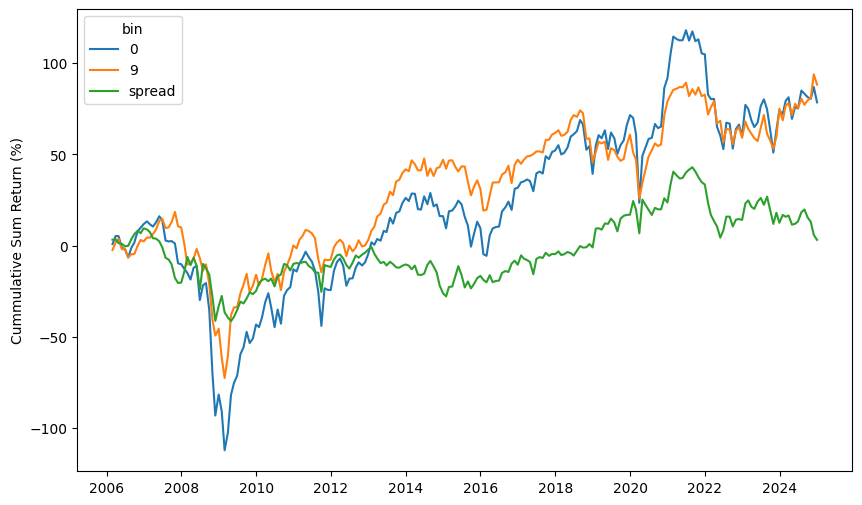

In [104]:
plt.figure(figsize=(10, 6))
sns.lineplot(
    port.filter(pl.col("bin").is_in(["0", "9", "spread"])), x="date", y="cumret", hue="bin"
)
plt.xlabel(None)
plt.ylabel("Cummulative Sum Return (%)")
plt.show()

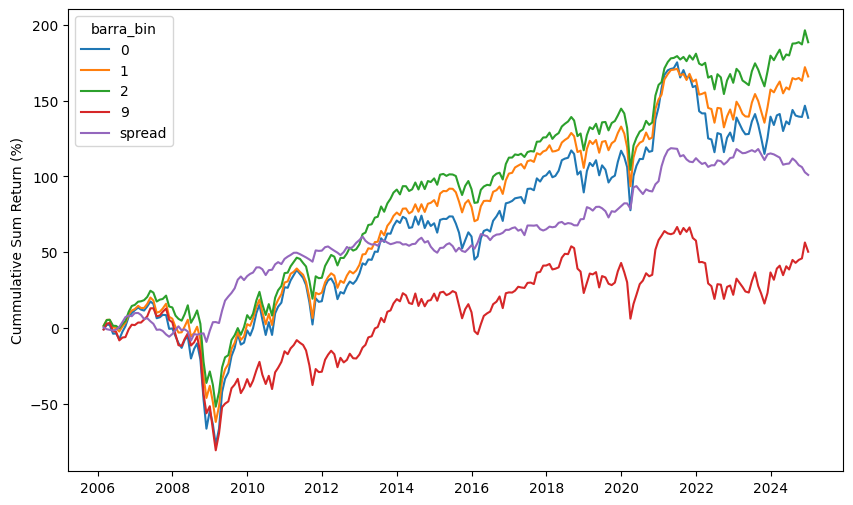

In [105]:
plt.figure(figsize=(10, 6))
sns.lineplot(
    barra_port.filter(pl.col("barra_bin").is_in(["0", "1", "2", "9", "spread"])),
    x="date",
    y="cumret",
    hue="barra_bin",
)
plt.xlabel(None)
plt.ylabel("Cummulative Sum Return (%)")
plt.show()

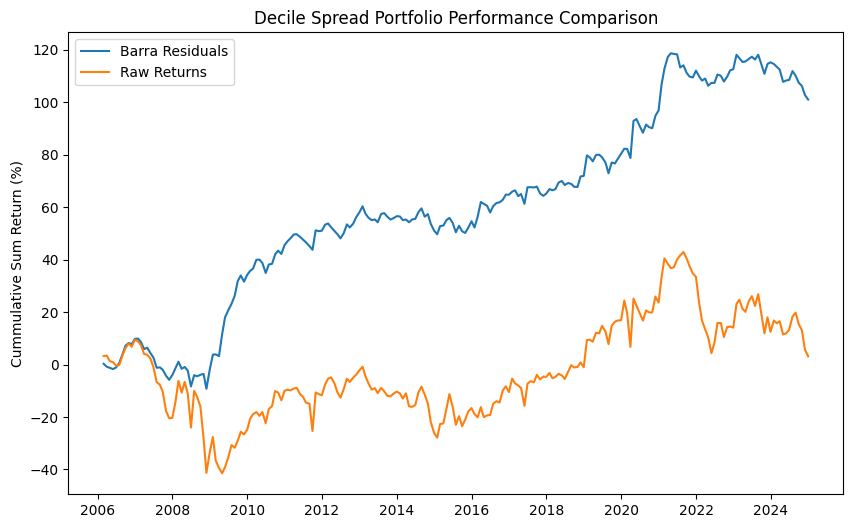

In [106]:
plt.figure(figsize=(10, 6))
sns.lineplot(
    barra_port.filter(pl.col("barra_bin").is_in(["spread"])),
    x="date",
    y="cumret",
    label="Barra Residuals",
)
sns.lineplot(
    port.filter(pl.col("bin").is_in(["spread"])), x="date", y="cumret", label="Raw Returns"
)
plt.legend()
plt.title("Decile Spread Portfolio Performance Comparison")
plt.xlabel(None)
plt.ylabel("Cummulative Sum Return (%)")
plt.show()

## THINGS TO DO:
- Figure out how to merge data to get volume for intuition test
- Test reversal window
- value weight? Optimizer? 
- add features similar to dipesh/miki (rolling sharpe)
